In [26]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = True  # plot every steps

# import floorplan analysis

In [27]:
from floorplan_analysis import read_bgr_from_image_unicode, get_unit_mask

# normalization

In [28]:
bgr = read_bgr_from_image_unicode("/fp_img/9765_107A.jpg")
# 9765_107A 누워있는
# 1776_105 코어
# 102487_266B 비사각
# plt.imshow(bgr)

In [29]:
unit_comb_orig = get_unit_mask(bgr)

In [30]:
unit_comb = unit_comb_orig.copy()

In [31]:
unit_comb.shape

(676, 923, 6)

In [32]:
unit_comb.sum(axis=(0, 1))

array([ 5667120,  1469565, 27330900, 27793215, 16453110,  4150635],
      dtype=uint64)

In [33]:
cv2.__version__

'4.2.0'

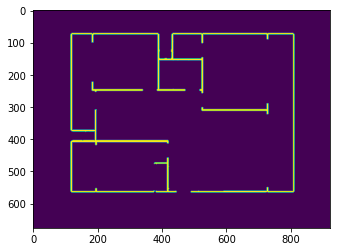

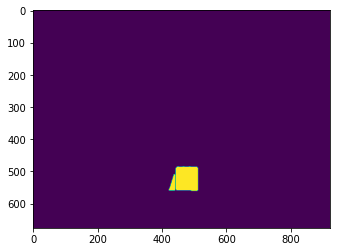

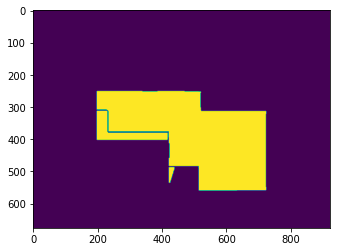

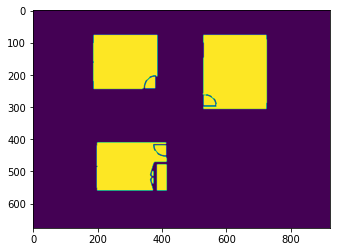

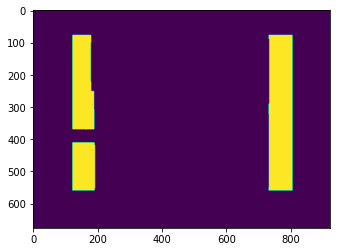

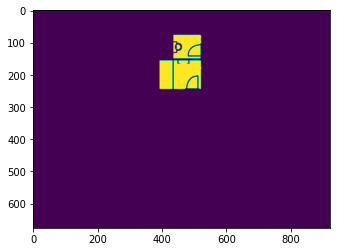

In [34]:
for i in range(6):
    plt.figure()
    plt.imshow(unit_comb[:, :, i])

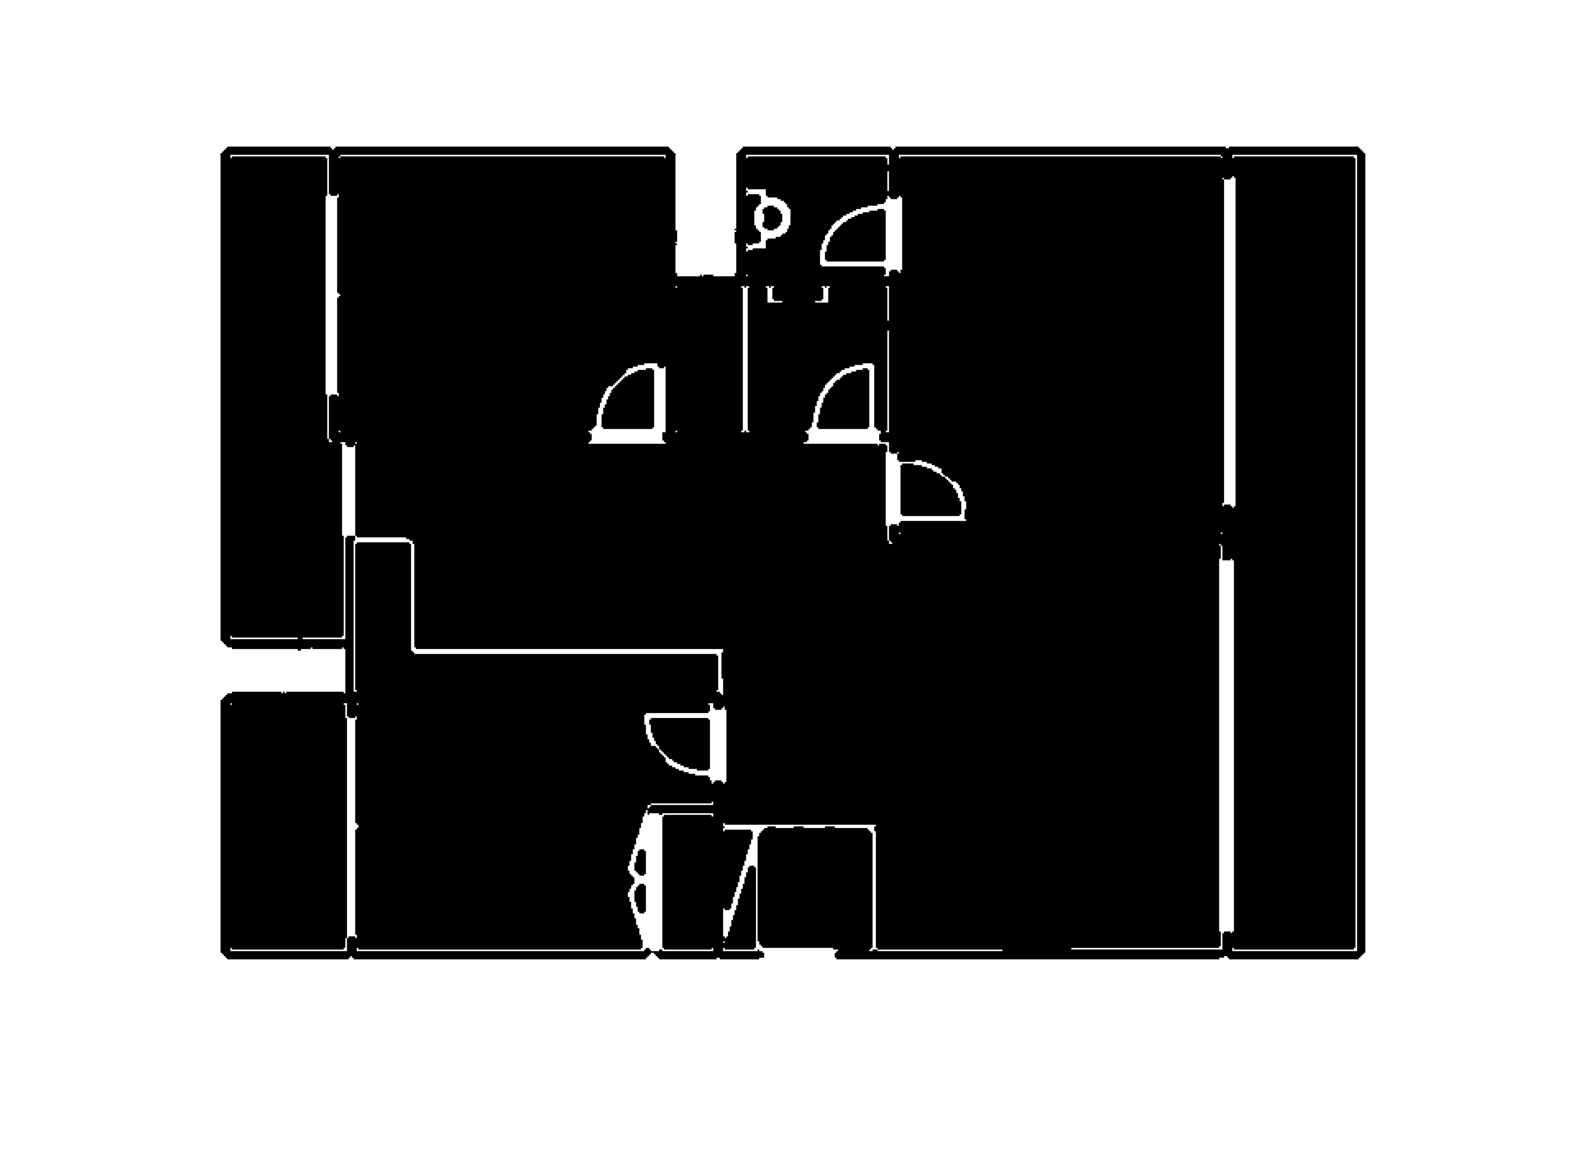

In [35]:
fig = plt.figure(figsize=(6, 4), dpi=300)
plt.axes().axis("off")
plt.imshow(
    np.bitwise_or.reduce(unit_comb, 2), cmap="binary",
)
plt.tight_layout()

In [36]:
bal_moments = cv2.moments(unit_comb[:, :, 4], True)
ind_moments = cv2.moments(np.bitwise_or.reduce(unit_comb, 2), True)

### make it down

if bal_moments["m00"] > 0:
    if (
        bal_moments["nu02"] / ind_moments["nu02"]
        > bal_moments["nu20"] / ind_moments["nu20"]
    ):
        #         print("down")
        pass
    elif (
        bal_moments["m10"] / bal_moments["m00"]
        < ind_moments["m10"] / ind_moments["m00"]
    ):
        #         print("left")
        unit_comb = np.rot90(unit_comb, 1)
    else:
        #         print("right")
        unit_comb = np.rot90(unit_comb, -1)
else:
    ldk_moments = cv2.moments(~unit_comb[:, :, 3], True)
    if ldk_moments["nu02"] >= ldk_moments["nu20"]:
        # print("down")
        pass
    elif (
        ldk_moments["m10"] / ldk_moments["m00"]
        < ind_moments["m10"] / ind_moments["m00"]
    ):
        # print("left")
        unit_comb = np.rot90(unit_comb, 1)
    else:
        # print("right")
        unit_comb = np.rot90(unit_comb, -1)

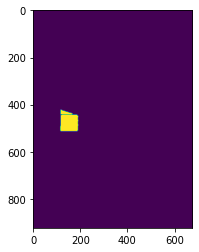

In [74]:
plt.imshow(unit_comb[:, :, 1])

In [71]:
### put entrance to left

ent_moments = cv2.moments(unit_comb[:, :, 1], True)
if ent_moments["m00"] and (
    (ent_moments["m10"] / ent_moments["m00"]) > (unit_comb.shape[1] / 2)
):
    # print("flip")
    unit_comb = np.flip(unit_comb, axis=1)

In [72]:
ent_moments["m10"] / ent_moments["m00"], ent_moments["m01"] / ent_moments["m00"]

(150.88408814853375, 473.1030713170224)

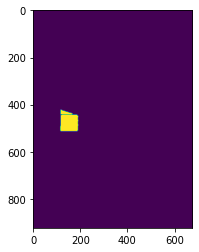

In [75]:
plt.imshow(unit_comb[:, :, 1])

85.0 260437
0.09032919194226995


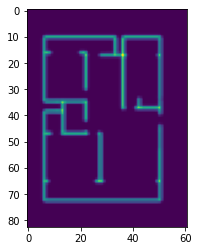

In [36]:
area = 85.0
target_ppm = 5  # pixels per meter

# indoor pixels excluding balcony
pixels = cv2.countNonZero(np.bitwise_or.reduce(unit_comb, 2) & ~unit_comb[:, :, 4])

print(area, pixels)

scale = sqrt(area * target_ppm ** 2 / pixels)
print(scale)

unit_scale = rescale(unit_comb, scale, mode="edge", multichannel=True)
plt.imshow(unit_scale[:, :, 0])

In [37]:
indexes = np.where(unit_scale != 0)

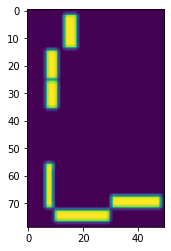

In [17]:
unit_clipped = unit_scale[
    min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
]
plt.imshow(unit_clipped[:, :, 4])

In [18]:
def align_fp(unit_comb):
    """put the main side to down and entrance to left"""

    def align_calc(unit_comb):
        def align_calc_x(unit_comb, cx):
            moment_half = cv2.moments(
                np.bitwise_or.reduce(unit_comb[:, cx:, :], 2), True
            )
            moment_bal = cv2.moments(unit_comb[:, cx:, 4], True)
            return moment_bal["m20"] / moment_half["m20"] * moment_half["m00"]

        def align_calc_y(unit_comb, cy):
            moment_half = cv2.moments(
                np.bitwise_or.reduce(unit_comb[cy:, :, :], 2), True
            )
            moment_bal = cv2.moments(unit_comb[cy:, :, 4], True)
            return moment_bal["m02"] / moment_half["m02"] * moment_half["m00"]

        x, y, w, h = cv2.boundingRect(np.bitwise_or.reduce(unit_comb, 2))
        cx, cy = x + w // 2, y + h // 2

        right, bottom = align_calc_x(unit_comb, cx), align_calc_y(unit_comb, cy)

        x, y, w, h = cv2.boundingRect(
            np.bitwise_or.reduce(cv2.rotate(unit_comb, cv2.ROTATE_180), 2)
        )
        cx, cy = x + w // 2, y + h // 2

        left, top = (
            align_calc_x(cv2.rotate(unit_comb, cv2.ROTATE_180), cx),
            align_calc_y(cv2.rotate(unit_comb, cv2.ROTATE_180), cy),
        )

        return top, bottom, left, right

    ind_moments = cv2.moments(np.bitwise_or.reduce(unit_comb, 2), True)
    ent_moments = cv2.moments(unit_comb[:, :, 1], True)

    if cv2.countNonZero(unit_comb[:, :, 4]):
        result = np.array(align_calc(unit_comb))
        # print(result)
        side = np.argmax(result)

        if side == 2:
            # print("left")
            unit_comb = np.rot90(unit_comb, 1)
        elif side == 3:
            # print("right")
            unit_comb = np.rot90(unit_comb, -1)
        else:
            # print("bottom?")
            pass

    else:
        ldk_moments = cv2.moments(~unit_comb[:, :, 3], True)

        if ldk_moments["nu02"] >= ldk_moments["nu20"]:
            # print("down")
            pass
        elif (
            ldk_moments["m10"] / ldk_moments["m00"]
            < ent_moments["m10"] / ent_moments["m00"]
        ):
            # print("left")
            unit_comb = np.rot90(unit_comb, 1)
        else:
            # print("right")
            unit_comb = np.rot90(unit_comb, -1)

    ### put entrance to left
    if (
        ent_moments["m10"] / ent_moments["m00"]
        > ind_moments["m10"] / ind_moments["m00"]
    ):
        # print("flip")
        unit_comb = np.flip(unit_comb, axis=1)

    return unit_comb

In [19]:
from skimage.transform import rescale


def rescale_fp(unit_comb, area, target_ppm=5, trim=True):
    # indoor pixels excluding balcony
    pixels = cv2.countNonZero(np.bitwise_or.reduce(unit_comb, 2) & ~unit_comb[:, :, 4])
    # print(area, pixels)

    scale = sqrt(area * target_ppm ** 2 / pixels)
    # print(scale)

    unit_scale = rescale(unit_comb, scale, mode="edge", multichannel=True)

    if trim:
        indexes = np.where(unit_scale != 0)
        unit_scale = unit_scale[
            min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
        ]

    return (unit_scale * 255).astype(np.uint8)

In [20]:
rescale_fp(unit_comb, 85)

array([[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0